In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from pprint import pprint

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 读取csv文件，生成dataset数据

### 1.1 读取csv文件

In [2]:
source_dir = "./generate_csv/"

def get_filenames_by_prefix(source_dir, prefix_name):
    all_files = os.listdir(source_dir)
    results = []
    for filename in all_files:
        if filename.startswith(prefix_name):
            results.append(os.path.join(source_dir, filename))
    return results

train_filenames = get_filenames_by_prefix(source_dir, "train")
valid_filenames = get_filenames_by_prefix(source_dir, "valid")
test_filenames = get_filenames_by_prefix(source_dir, "test")

pprint(train_filenames[:3])
pprint(valid_filenames[:3])
pprint(test_filenames[:3])

['./generate_csv/train_00.csv',
 './generate_csv/train_01.csv',
 './generate_csv/train_02.csv']
['./generate_csv/valid_00.csv',
 './generate_csv/valid_01.csv',
 './generate_csv/valid_02.csv']
['./generate_csv/test_00.csv',
 './generate_csv/test_01.csv',
 './generate_csv/test_02.csv']


### 1.2 解析并生成dataset数据

In [3]:
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields
    parsed_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_fields[:-1])
    y = tf.stack(parsed_fields[-1:])        # scaler是没有维度的，所以需要显式指                                             # 定维度
    return x, y

def csv_reader_dataset(filenames, n_readers=5, batch_size=32, 
                       n_parse_threads=5, shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()   
    dataset = dataset.interleave(
                lambda filename: tf.data.TextLineDataset(filename).skip(1),
                cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line,
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 32
train_set = csv_reader_dataset(train_filenames, batch_size=batch_size)
valid_set = csv_reader_dataset(valid_filenames, batch_size=batch_size)
test_set = csv_reader_dataset(test_filenames, batch_size=batch_size)

## 2. 生成tfrecord文件

In [4]:
def serialize_example(x, y):
    input_features = tf.train.FloatList(value=x)
    label = tf.train.FloatList(value=y)
    features = tf.train.Features(
        feature = {
            "input_features": tf.train.Feature(float_list=input_features),
            "label": tf.train.Feature(float_list=label)
            }
    )
    example =tf.train.Example(features=features)
    return example.SerializeToString()

In [5]:
"""在视频教程中生成tfrecord文件没有在filename_fullpath中加.tfrecord后缀，在生成tfrecord压缩文件时也没有加.zip，所以都只有文件名没有后缀，而如果加上这些后缀生成.tfrecord 和 .zip文件时，.tfrecord大小和没有.tfrecord后缀的文件大小一致，而加了.zip的压缩文件居然和原文件大小一致，所以对加不加后缀有什么区别这一点有很大疑惑
filename_fullpath = "{}_{:03d}-of-{:03d}.tfrecord.zip".format(base_filename, shard_id, n_shards)"""

def csv_dataset_to_tfrecords(base_filename, dataset, n_shards,
                             steps_per_shard, compression_type=None):
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    all_filenames = []
    for shard_id in range(n_shards):
        filename_fullpath = "{}_{:03d}-of-{:03d}".format(base_filename,
                                                         shard_id, n_shards)
        with tf.io.TFRecordWriter(filename_fullpath, options) as writer:
            """dataset.take(steps_per_shard)根据视频中的解释是接力式的读取数据，即                从当前位置（不一定是起始位置）开始读取steps_per_shard个batch"""
            for x_batch, y_batch in dataset.take(steps_per_shard):
                for x_example, y_example in zip(x_batch, y_batch):
                    writer.write(serialize_example(x_example, y_example))
        all_filenames.append(filename_fullpath)
    return all_filenames

In [6]:
n_shards = 20
# 每个文件有多少个 batch
train_steps_per_shard = 11610 // batch_size // n_shards
valid_steps_per_shard = 3880 // batch_size // n_shards
test_steps_per_shard = 5170 // batch_size // n_shards

output_dir = "generate_tfrecords"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
train_basename = os.path.join(output_dir, "train")
valid_basename = os.path.join(output_dir, "valid")
test_basename = os.path.join(output_dir, "test")

train_tfrecord_filenames = csv_dataset_to_tfrecords(base_filename=train_basename,
                         dataset=train_set,
                         n_shards=n_shards,
                         steps_per_shard=train_steps_per_shard,
                         compression_type=None)
valid_tfrecord_filenames = csv_dataset_to_tfrecords(base_filename=valid_basename,
                         dataset=valid_set,
                         n_shards=n_shards,
                         steps_per_shard=valid_steps_per_shard,
                         compression_type=None)
test_tfrecord_filenames = csv_dataset_to_tfrecords(base_filename=test_basename,
                         dataset=test_set,
                         n_shards=n_shards,
                         steps_per_shard=test_steps_per_shard,
                         compression_type=None)


In [7]:
pprint(train_tfrecord_filenames[:3])
pprint(valid_tfrecord_filenames[:3])
pprint(test_tfrecord_filenames[:3])

['generate_tfrecords\\train_000-of-020',
 'generate_tfrecords\\train_001-of-020',
 'generate_tfrecords\\train_002-of-020']
['generate_tfrecords\\valid_000-of-020',
 'generate_tfrecords\\valid_001-of-020',
 'generate_tfrecords\\valid_002-of-020']
['generate_tfrecords\\test_000-of-020',
 'generate_tfrecords\\test_001-of-020',
 'generate_tfrecords\\test_002-of-020']


## 3. 生成压缩后的tfrecord文件（非zip文件）

In [8]:
n_shards = 20
train_steps_per_shard = 11610 // batch_size // n_shards
valid_steps_per_shard = 3880 // batch_size // n_shards
test_steps_per_shard = 5170 // batch_size // n_shards

output_dir = "generate_tfrecords_zip"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
train_basename = os.path.join(output_dir, "train")
valid_basename = os.path.join(output_dir, "valid")
test_basename = os.path.join(output_dir, "test")

train_tfrecord_filenames =                                                         csv_dataset_to_tfrecords(base_filename=train_basename,
                             dataset=train_set,
                             n_shards=n_shards,                                                            steps_per_shard=train_steps_per_shard,
                             compression_type="GZIP")
valid_tfrecord_filenames =                                                         csv_dataset_to_tfrecords(base_filename=valid_basename,
                             dataset=valid_set,
                             n_shards=n_shards,                                                            steps_per_shard=train_steps_per_shard,
                             compression_type="GZIP")
test_tfrecord_filenames =                                                         csv_dataset_to_tfrecords(base_filename=test_basename,
                             dataset=test_set,
                             n_shards=n_shards,                                                            steps_per_shard=train_steps_per_shard,
                             compression_type="GZIP")

In [9]:
pprint(train_tfrecord_filenames[:3])
pprint(valid_tfrecord_filenames[:3])
pprint(test_tfrecord_filenames[:3])

['generate_tfrecords_zip\\train_000-of-020',
 'generate_tfrecords_zip\\train_001-of-020',
 'generate_tfrecords_zip\\train_002-of-020']
['generate_tfrecords_zip\\valid_000-of-020',
 'generate_tfrecords_zip\\valid_001-of-020',
 'generate_tfrecords_zip\\valid_002-of-020']
['generate_tfrecords_zip\\test_000-of-020',
 'generate_tfrecords_zip\\test_001-of-020',
 'generate_tfrecords_zip\\test_002-of-020']


## 4.读取tfrecord文件（压缩后的文件）

In [10]:
expected_features = {
    "input_features": tf.io.FixedLenFeature([8], dtype=tf.float32),
    "label": tf.io.FixedLenFeature([1], dtype=tf.float32)}

def parse_example(serialized_example):
    example = tf.io.parse_single_example(serialized_example,                                                            expected_features)
    return example["input_features"], example["label"]

def tfrecords_reader_dataset(filenames, n_readers=5, batch_size=32, 
                             n_parse_threads=5, shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()   
    dataset = dataset.interleave(
                lambda filename: tf.data.TFRecordDataset(filename, 
                compression_type="GZIP"),
                cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_example,
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

# 简单测试
tfrecords_train = tfrecords_reader_dataset(train_tfrecord_filenames,                                                      batch_size=3)
for x_batch, y_batch in tfrecords_train.take(2):
    print(x_batch)
    print(y_batch)
    print("------------------")

tf.Tensor(
[[-0.01600986  0.3487751  -0.145162   -0.16849221  0.6929859   0.03414744
  -0.8524867   0.8469173 ]
 [-1.4568672   1.0612164  -0.673559   -0.14353533 -0.4633915   0.05630484
  -0.80588955  0.67300326]
 [-0.43625548 -1.7093886  -0.09519526 -0.06609064  0.70982206 -0.05648747
   2.2928212  -1.3593059 ]], shape=(3, 8), dtype=float32)
tf.Tensor(
[[2.118]
 [0.854]
 [1.017]], shape=(3, 1), dtype=float32)
------------------
tf.Tensor(
[[-0.43625548 -1.7093886  -0.09519526 -0.06609064  0.70982206 -0.05648747
   2.2928212  -1.3593059 ]
 [-0.27877632  0.26961493 -0.44563687 -0.09520677  1.2317426  -0.02799864
  -0.72667444  0.76244473]
 [ 0.5127651  -0.91778713  0.20631802  0.05494679  3.5843725  -0.03017361
   0.82501084 -1.4040266 ]], shape=(3, 8), dtype=float32)
tf.Tensor(
[[1.017]
 [2.141]
 [3.543]], shape=(3, 1), dtype=float32)
------------------


In [11]:
batch_size = 32
tfrecords_train_set = tfrecords_reader_dataset(train_tfrecord_filenames,                                                      batch_size=batch_size)
tfrecords_valid_set = tfrecords_reader_dataset(valid_tfrecord_filenames,                                                      batch_size=batch_size)
tfrecords_test_set = tfrecords_reader_dataset(test_tfrecord_filenames,                                                       batch_size=batch_size) 

for x_batch, y_batch in tfrecords_train.take(1):
    print(x_batch)
    print(y_batch)

tf.Tensor(
[[-0.43625548 -1.7093886  -0.09519526 -0.06609064  0.70982206 -0.05648747
   2.2928212  -1.3593059 ]
 [-0.01600986  0.3487751  -0.145162   -0.16849221  0.6929859   0.03414744
  -0.8524867   0.8469173 ]
 [-0.01600986  0.3487751  -0.145162   -0.16849221  0.6929859   0.03414744
  -0.8524867   0.8469173 ]], shape=(3, 8), dtype=float32)
tf.Tensor(
[[1.017]
 [2.118]
 [2.118]], shape=(3, 1), dtype=float32)


## 5. 定义并训练模型

In [12]:
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_dim=8),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = model.fit(tfrecords_train_set, 
                    epochs=100,
                    validation_data=tfrecords_valid_set,
                    steps_per_epoch = 11150 // batch_size,
                    validation_steps = 3870 // batch_size,             
                    callbacks = callbacks)

Train for 348 steps, validate for 120 steps
Epoch 1/100
348/348 [==============================] - 1s 3ms/step - loss: 0.7710 - val_loss: 0.6402
Epoch 2/100
348/348 [==============================] - 0s 1ms/step - loss: 0.5064 - val_loss: 0.5444
Epoch 3/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4691 - val_loss: 0.5326
Epoch 4/100
348/348 [==============================] - 1s 1ms/step - loss: 0.4398 - val_loss: 0.4929
Epoch 5/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4306 - val_loss: 0.4868
Epoch 6/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4165 - val_loss: 0.4653
Epoch 7/100
348/348 [==============================] - 0s 1ms/step - loss: 0.4088 - val_loss: 0.4913
Epoch 8/100
348/348 [==============================] - 0s 1ms/step - loss: 0.3995 - val_loss: 0.4900
Epoch 9/100
348/348 [==============================] - 0s 1ms/step - loss: 0.3934 - val_loss: 0.4537
Epoch 10/100
348/348 [=========================

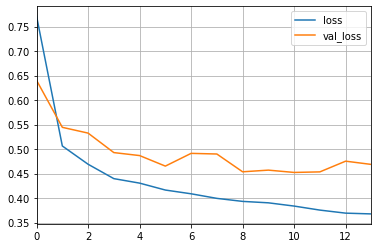

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(6, 4))
    plt.grid(True)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(tfrecords_test_set, steps= 5160 // batch_size)

161/161 [==============================] - 0s 832us/step - loss: 0.4084


0.408448295795029